**Parkinson’s disease (PD) patients** 
- Subjects:
    - S1 - S10
    - S13 - S14
    - S16 - S21
- Total: 18
- Proportion: 54%
- Sessions: 8 - 11, except S16, 5

**Healthy controls**
- Subjects: 
    - S11 - S12
    - S15
    - S22 - S33 
- Total: 15
- Proportion: 45%
- Sessions: 8-11

In [ ]:
import pandas as pd 
import numpy as np
import os
from os import walk
import statistics
from matplotlib import pyplot as pt
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mannwhitneyu
import math 
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from tqdm.notebook import tqdm
%matplotlib inline
from matplotlib import pyplot as plt
#from google.colab import drive

#drive.mount('/content/gdrive')

In [ ]:
#Read data
n_subjects = 33
press = []
release = []
pressure = []
ses = []
sub = []

for subject in list(range(1, n_subjects+1)):
    subjectID = str(subject).zfill(2)
    #path_to_data = "/content/gdrive/MyDrive/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Data"+ "/S" + subjectID
    path_to_data = "/Users/mariabaeza/Desktop/Universidad/BigData/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Data"+  "/S" + subjectID
    os.chdir(path_to_data)
    _, _, filenames = next(walk(path_to_data))
    for session in filenames:
        if session != ".DS_Store":
            with open(session) as f:
                lines = f.read().splitlines()
                for line in lines:
                    if line != "":
                        x = line.split(",")
                        y = x[2].split(" ")
                        press.append(int(x[1]))
                        release.append(int(y[1]))
                        pressure.append(float(x[3]))
                        ses.append(int(session.split("_")[1].split(".")[0].split("TEX")[1]))
                        sub.append(int(subject))

In [ ]:
#Create dataframe
data = {'PressTime':  press,
        'ReleaseTime': release,
        'Pressure': pressure,
        'SessionID': ses,
        'SubjectID': sub
        }

df = pd.DataFrame (data, columns = ['PressTime','ReleaseTime','Pressure','SessionID','SubjectID'])

pd_patients = [1,2,3,4,5,6,7,8,9,10,13,14,16,17,18,19,20,21]
df['Class'] = np.zeros(len(df))
df["Class"]=df.SubjectID.apply(lambda x: x in pd_patients,1)
df.head()

,PressTime,ReleaseTime,Pressure,SessionID,SubjectID,Class
0,16616858,16616929,0.5875,3,1,True
1,16617771,16617851,0.5750,3,1,True
2,16619119,16619197,0.6250,3,1,True
3,16619755,16619854,0.6125,3,1,True
4,16620751,16620866,0.7125,3,1,True


In [ ]:
df['Time']= np.zeros(len(df))
for subject, session in df.groupby(["SubjectID","SessionID"]): 
    time_session = session.PressTime - session.PressTime.iloc[0]
    df.iloc[time_session.index,6] = time_session/1000
df.head()

,PressTime,ReleaseTime,Pressure,SessionID,SubjectID,Class,Time
0,16616858,16616929,0.5875,3,1,True,0.000
1,16617771,16617851,0.5750,3,1,True,0.913
2,16619119,16619197,0.6250,3,1,True,2.261
3,16619755,16619854,0.6125,3,1,True,2.897
4,16620751,16620866,0.7125,3,1,True,3.893


In [ ]:
#df.to_csv("/Users/mariabaeza/Desktop/Universidad/BigData/TFM/data.csv")

$HT_n = t_n^r - t_n^p, n=1,2,...,N$

$FT_n = t_{n-1}^p - t_n^r, n=1,2,..., N-1$

In [ ]:
#Number of keys for each subject and session
df.groupby(["SubjectID","SessionID"]).size()

SubjectID  SessionID
1          1            195
           2             49
           3             57
           4             47
           5             57
                       ... 
33         6             88
           7             67
           8             52
           9             95
           10            50
Length: 338, dtype: int64

In [ ]:
df_feat = pd.DataFrame()
df_feat['NP'] = df['Pressure']
df_feat["HT"] = df["ReleaseTime"] - df["PressTime"]
df_feat["FT"] = np.zeros(len(df))
df_feat["SessionID"] =  df['SessionID']
df_feat["SubjectID"] =  df['SubjectID']
for subject, session in df.groupby(["SubjectID","SessionID"]): 
    iterkey = session.iterrows()
    for index, row in iterkey:
        df_feat.iloc[index-1,2] = df.iloc[index ,0] - df.iloc[index - 1,1]
df_feat['Class'] = df.Class
df_feat['Time'] = df.Time
df_feat.head()
#Drop first value of each session and patient? 

,NP,HT,FT,SessionID,SubjectID,Class,Time
0,0.5875,71,842.0,3,1,True,0.000
1,0.5750,80,1268.0,3,1,True,0.913
2,0.6250,78,558.0,3,1,True,2.261
3,0.6125,99,897.0,3,1,True,2.897
4,0.7125,115,1989.0,3,1,True,3.893


In [ ]:
class RawFeaturesCleaner:
  # We are setting the defaults to what we observed and recommended in the
  # exploration steps detailed in `02_loading_and_exploring.ipynb`
  UNWANTED_COLUMNS = ['date','timestamp','flight_time']
  HOLD_TIME_OUTLIER_THRESHOLD = 1000
  MINIMUM_OBSERVATIONS_PER_USER = 1000
  EXCLUDE_HIGH_IMPACT_CLASSES = ['Medium', 'Severe']
  EXCLUDE_USERS_TAKING = []
  
  def __init__(self, options={}):
    self.unwanted_columns = self.UNWANTED_COLUMNS
    self.hold_time_outlier_threshold = self.HOLD_TIME_OUTLIER_THRESHOLD
    self.minimum_observations_per_user = self.MINIMUM_OBSERVATIONS_PER_USER
    self.exclude_high_impact_classes = self.EXCLUDE_HIGH_IMPACT_CLASSES
    self.exclude_users_taking = self.EXCLUDE_USERS_TAKING
    
    if 'unwanted_columns' in options:
      self.unwanted_columns = options['unwanted_columns']
    if 'hold_time_outlier_threshold' in options:
      self.hold_time_outlier_threshold = options['hold_time_outlier_threshold']
    if 'minimum_observations_per_user' in options:
      self.minimum_observations_per_user = options['minimum_observations_per_user']
    if 'exclude_high_impact_classes' in options:
      self.exclude_high_impact_classes = options['exclude_high_impact_classes']
    if 'exclude_users_taking' in options:
      self.exclude_users_taking = options['exclude_users_taking']
  
  def discard_subject(self, df):
    indexes = df[df.SubjectID == 16].index
    df.drop(indexes, inplace=True)
    return self

  
  def discard_hold_time_outliers(self, df):
    indexes = df[df.HT > self.hold_time_outlier_threshold].index
    df.drop(indexes, inplace=True)
    return self
  

In [ ]:
cleaner = RawFeaturesCleaner()

# During the exploration we found out 4 users with parkinsons that did not report
# their `impact`. We should fill them with the mode because we might use the impact
# to select different datasets (i.e. exclude users with `Severe` impact since we
# want to detect early stages of the disease
#cleaner.fill_impact_nan_with_mode(df)

# We want to discard date and time since we don't plan to use it.
# We'll also discard flight time since we notice discrepancies in the data there, 
# and flight time is present inside hold time, so we don't need both
#cleaner.discard_unwanted_columns(df)

# We don't want to deal with hold time higher than 1 second
cleaner.discard_hold_time_outliers(df_feat)

cleaner.discard_subject(df_feat)

# All `S` observations should also be discarded since we just want to detect

# We should also discard users with very few observations so their "weak"
# stats don't affect the whole dataset, producing noise in the data
#cleaner.discard_users_with_few_observations(df_feat)

# We should focus on those with mild severity because we want to detect
# early stages of the disease
#cleaner.discard_users_with_high_impact(df)

# After some roundtrips between training models and feature engineering, we noticed
# that users taking medicine might affect the results of the research because they
# will have PD but not display the symptoms
#cleaner.discard_users_taking_medicine(df)

# At this point we have a clean raw dataset to start feature engineering steps
# by applying some stats on the data on ~100 users (depending on the params
# for the initial cleanup)
print(f'Number of users: {df_feat.SubjectID.nunique()}')
df.head()

Number of users: 32


,PressTime,ReleaseTime,Pressure,SessionID,SubjectID,Class,Time
0,16616858,16616929,0.5875,3,1,True,0.000
1,16617771,16617851,0.5750,3,1,True,0.913
2,16619119,16619197,0.6250,3,1,True,2.261
3,16619755,16619854,0.6125,3,1,True,2.897
4,16620751,16620866,0.7125,3,1,True,3.893


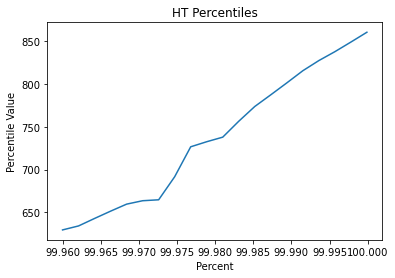

After the percentile 99.990 we see significantly higher values, which are definitely outliers.
Filtered out 3 rows with outliers in column 'HT'


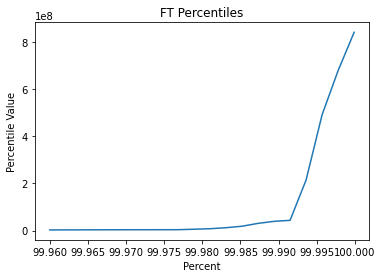

After the percentile 99.990 we see significantly higher values, which are definitely outliers.
Filtered out 3 rows with outliers in column 'FT'


In [ ]:
def filter_column_by_quantile(df, column, threshold):
    len_before = len(df)
    df = df[df[column] < np.percentile(df[column], threshold)]
    len_after = len(df)
    print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
    return df


def plot_percentiles_of_column(df, col, start, end, bins):
    X = np.linspace(start, end, bins)
    Y = [np.percentile(df[col], x) for x in X]
    plt.plot(X, Y)
    plt.title(col + " Percentiles")
    plt.xlabel("Percent")
    plt.ylabel("Percentile Value")
    plt.show()

    
# Filter out outliers of HoldTime:
plot_percentiles_of_column(df_feat, 'HT', 99.96, 99.9999, 20)
print("After the percentile 99.990 we see significantly higher values, which are definitely outliers.")
df_feat = filter_column_by_quantile(df_feat, 'HT', 99.990)

# Filter out outliers of Fligth:
plot_percentiles_of_column(df_feat, 'FT', 99.96, 99.9999, 20)
print("After the percentile 99.990 we see significantly higher values, which are definitely outliers.")
df_feat = filter_column_by_quantile(df_feat, 'FT', 99.990)

In [ ]:
#NFT Normalization (Iakovakis19)
df_nft = pd.DataFrame()
df_nft = df_feat

df_nft = df_nft.drop(df_nft[(df_nft['FT'] > 3000)].index) #more than 3 seconds 
df_nft['NFT']=(df_nft.FT-df_nft.groupby(["SubjectID","SessionID"]).FT.transform('mean'))#
df_nft = df_nft.drop(df_nft[((df_nft['NFT'] > 1700) | (df_nft['NFT'] < -1270))].index) #conditional filtering step. 
df_nft

,NP,HT,FT,SessionID,SubjectID,Class,Time,NFT
107,0.3875,115,1039.0,1,1,True,12.073,86.458101
108,0.5625,108,590.0,1,1,True,13.227,-362.541899
109,0.5000,115,2644.0,1,1,True,13.925,1691.458101
110,0.6250,98,1099.0,1,1,True,16.684,146.458101
111,0.8125,114,1758.0,1,1,True,17.881,805.458101
...,...,...,...,...,...,...,...,...
26284,0.4750,71,152.0,9,33,False,35.607,981.276596
26285,0.6875,73,242.0,9,33,False,35.830,1071.276596
26286,0.5250,65,217.0,9,33,False,36.145,1046.276596
26287,0.6875,49,168.0,9,33,False,36.427,997.276596


In [ ]:
#df_feat.to_csv("/Users/mariabaeza/Desktop/Universidad/BigData/TFM/data_feat.csv")

In [ ]:
holdTimeCounters = df_feat.groupby(['HT']).HT.count().sort_values()
print("10 most common values in 'HoldTime' and their count:\n")
print(holdTimeCounters.tail(10))
hist = holdTimeCounters.hist(bins=100).set(xlabel="Count of occurrences of a 'HoldTime' value", ylabel="Count of unique values")

SAVE PREPROCESSING

In [ ]:
import pickle
#os.chdir("/content/gdrive/MyDrive/TFM")
os.chdir("/Users/mariabaeza/Desktop/Universidad/BigData/TFM")
# Saving the objects:
with open('preprocessing.pkl', 'wb') as f:  # Python 3: open(..., 'wb')s
    pickle.dump([df_feat, df_nft, df, pd_patients], f)



In [ ]:
# Getting back the objects:
with open('preprocessing.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    df_feat, df_nft, df, pd_patients = pickle.load(f)

# Features 

Proposed by Iakovakis (2019)
- Mean of HT and NP  // New: Median, min, max? ? 
- Standard deviation of HT. Repetir todos los features. 
- Skewness of NFT. 

Proposed by Tian (2019)
- Calcular en ventans pequeñas (5 elementos, probar) 
- Typing Velocity and acceleration -> min,max, mean, median, std // New: skewness and kurtorsis? 
- Pressure change and jerk -> min, max, mean, median, std // New: skewness and kurtorsis?. 

Proposed by Giancardo (2016) (only HT) 
- Key press coordination
- Histogram bins: 0,1,2,3 ?

Windows 
- 15s non overalapping? (cambiar?)
- secuencias no completas zero padding.

<AxesSubplot:title={'center':'HT'}, xlabel='Class'>

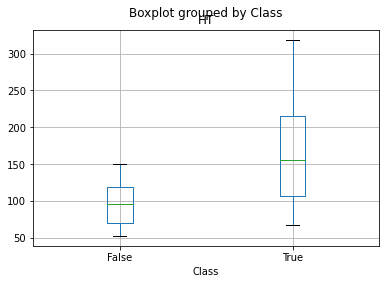

In [ ]:
df_feat.groupby(["SubjectID","SessionID"]).mean().boxplot(column=['HT'],by="Class" )

<AxesSubplot:title={'center':'NP'}, xlabel='Class'>

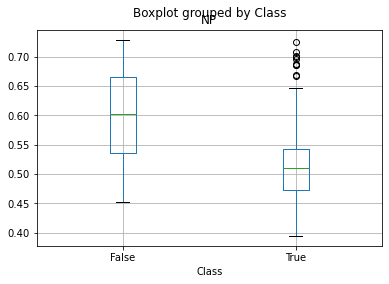

In [ ]:
df_feat.groupby(["SubjectID","SessionID"]).mean().boxplot(column=['NP'],by="Class")

In [ ]:
time_1 = df_feat.loc[(df_feat.SubjectID == 1) & (df_feat.SessionID ==7)].Time
NP_1 = df_feat.loc[(df_feat.SubjectID == 1) & (df_feat.SessionID ==7)].NP

Text(0.5, 1.0, 'NP')

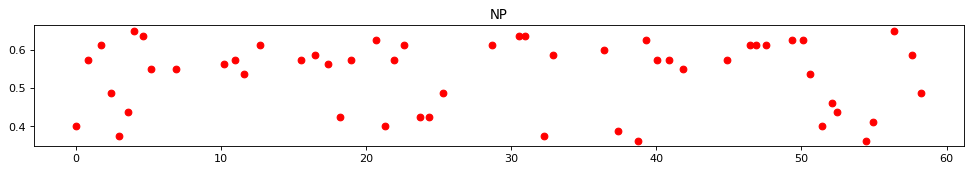

In [ ]:
pt.figure(num=None, figsize=(15, 2), dpi=80, facecolor='w', edgecolor='k')
pt.plot(time_1, NP_1,'bo', c = 'r')
pt.title("NP")

(array([2., 0., 2., 0., 1., 0., 3., 0., 1., 0., 3., 0., 0., 2., 0., 0., 0.,
        1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 3., 0.,
        2., 0., 8., 0., 0., 3., 0., 1., 0., 7., 0., 4., 0., 3., 0., 2.]),
 array([0.3625    , 0.36825   , 0.374     , 0.37975   , 0.3855    ,
        0.39125   , 0.397     , 0.40275001, 0.40850001, 0.41425001,
        0.42000001, 0.42575001, 0.43150001, 0.43725001, 0.44300001,
        0.44875001, 0.45450001, 0.46025001, 0.46600001, 0.47175002,
        0.47750002, 0.48325002, 0.48900002, 0.49475002, 0.50050002,
        0.50625002, 0.51200002, 0.51775002, 0.52350002, 0.52925002,
        0.53500002, 0.54075002, 0.54650003, 0.55225003, 0.55800003,
        0.56375003, 0.56950003, 0.57525003, 0.58100003, 0.58675003,
        0.59250003, 0.59825003, 0.60400003, 0.60975003, 0.61550004,
        0.62125004, 0.62700004, 0.63275004, 0.63850004, 0.64425004,
        0.65000004]),
 <BarContainer object of 50 artists>)

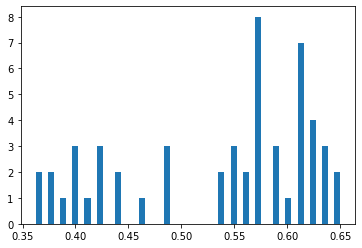

In [ ]:
pt.hist(NP_1, bins = 50)

In [ ]:
def class_def(element):
    label=0
    if element in pd_patients:
        label=1
    return label

def obtain_stats(input_df, variable,min_elem):
    df = pd.DataFrame()
    prev_subject = 0
    prev_session = 0
    name_variable= input_df.columns[variable]
    window_time = 15 #CAN BE CHANGED
    first_index = []
    for subject, session in input_df.groupby(["SubjectID","SessionID"]): 
        iterkey_new = session.iterrows()
        n=0
        window = []
        for index, row in iterkey_new:
            if row.SubjectID != prev_subject or row.SessionID != prev_session:
                first_index = index
                prev_subject = row.SubjectID
                prev_session = row.SessionID
            
            if (input_df.loc[index].Time<window_time*(n+1)+input_df.loc[first_index].Time) and (input_df.loc[index].Time>=window_time*(n)+input_df.loc[first_index].Time):
                if math.isnan(input_df.loc[index].iloc[variable])==0:
                    window.append(input_df.loc[index].iloc[variable])
            else:
                if len(window)>=min_elem:
                    data = {'Mean': statistics.mean(window), 'Median': statistics.median(window), 'SD': np.std(window),'Skewness': skew(window),'Kurtosis': kurtosis(window),'SessionID': row.SessionID , 'SubjectID': row.SubjectID}
                    df = df.append(pd.DataFrame(data, columns = ["Mean","Median","SD","Skewness","Kurtosis","SessionID","SubjectID"] , index=[0]))
                window = []
                window.append(input_df.loc[index].iloc[variable])
                n += 1
        if len(window)>=min_elem:
            data = {'Mean': statistics.mean(window), 'Median': statistics.median(window), 'SD': np.std(window),'Skewness': skew(window),'Kurtosis': kurtosis(window),'SessionID': row.SessionID , 'SubjectID': row.SubjectID}
            df = df.append(pd.DataFrame(data, columns = ["Mean","Median","SD","Skewness","Kurtosis","SessionID","SubjectID"] , index=[0]))
    
    df_session_mean = df.groupby(["SubjectID","SessionID"]).mean()
    df_session_std = df.groupby(["SubjectID","SessionID"]).std()
    df_session_mean.columns = [name_variable+" Mean",name_variable+" Median",name_variable+" SD",name_variable+" Skewness",name_variable+" Kurtosis"]
    df_session_std.columns = [name_variable+" SD Mean",name_variable+" SD Median",name_variable+" SD SD",name_variable+" SD Skewness",name_variable+" SD Kurtosis"]
    df_session = pd.concat([df_session_mean, df_session_std], axis=1)
    df_session['Class'] = np.zeros(len(df_session))
    df_session['Class']= list(map(class_def, df_session.index.get_level_values('SubjectID').values))
    return df_session

In [ ]:
df_NFT = obtain_stats(df_nft,7,4)

In [ ]:
df_NP = obtain_stats(df_feat,0,4)
df_HT = obtain_stats(df_feat,1,4)

In [ ]:
## Velocity and acceleration
df_new = pd.DataFrame()
count = 0
for subject, session in df_feat.groupby(["SubjectID","SessionID"]): 
    iterkey_new = session.iterrows()
    n_elements = 5 #CAN BE CHANGED
    size = 0
    window_v = []
    for index,row in iterkey_new: 
        if size==0:
            time_begin = df_feat.loc[index].Time
            size += 1
        elif size < n_elements:
            size += 1
        else:
            time_end = df_feat.loc[index].Time
            size = 0
            data_v = {'Velocity': n_elements/(time_end - time_begin), 'Acceleration': n_elements/(time_end - time_begin)**2,'Time': time_begin,'SessionID': row.SessionID , 'SubjectID': row.SubjectID}
            df_new = df_new.append(pd.DataFrame(data_v, columns = ["Velocity","Acceleration","Time","SessionID","SubjectID"], index=[count]))
            count+=1

In [ ]:
df_v = obtain_stats(df_new,0,0)
df_a = obtain_stats(df_new,1,0)

In [ ]:
df_v

Velocity Mean  Velocity Median  Velocity SD  \
SubjectID SessionID                                                
1.0       1.0             0.773873         0.775275     0.076589   
          2.0             0.914206         0.939612     0.104840   
          3.0             0.767016         0.760267     0.060367   
          4.0             1.082144         1.088760     0.110426   
          5.0             0.748542         0.732181     0.122656   
...                            ...              ...          ...   
33.0      6.0             2.816752         2.879375     0.402024   
          7.0             2.854151         3.104500     0.901726   
          8.0             2.360886         2.403151     0.606985   
          9.0             2.889104         2.880008     0.411536   
          10.0            2.933685         3.182874     0.456708   

                     Velocity Skewness  Velocity Kurtosis  Velocity SD Mean  \
SubjectID SessionID                                                           
1.0       1.0                -0.004573          -2.277778          0.242000   
          2.0                -0.286774          -2.074680          0.149391   
          3.0                 0.061829          -2.300000          0.310638   
          4.0                -0.084649          -1.833333          0.235517   
          5.0                 0.073098          -2.300000          0.369835   
...                                ...                ...               ...   
33.0      6.0                -0.101508          -1.562704          0.430638   
          7.0                -0.639543          -0.956420          0.049982   
          8.0                 0.456820          -0.702180          0.432764   
          9.0                 0.177395          -1.473637          0.473315   
          10.0               -0.359452          -2.097952          0.020404   

                     Velocity SD Median  Velocity SD SD  Velocity SD Skewness  \
SubjectID SessionID                                                             
1.0       1.0                  0.237101        0.083631              0.228429   
          2.0                  0.158520        0.123303              0.371060   
          3.0                  0.304365        0.070130              0.138254   
          4.0                  0.226581        0.019693              0.146616   
          5.0                  0.356836        0.158699              0.163451   
...                                 ...             ...                   ...   
33.0      6.0                  0.395391        0.183917              0.277711   
          7.0                  0.361327        0.357812              0.533273   
          8.0                  0.746255        0.280120              1.291676   
          9.0                  0.481727        0.198126              0.168695   
          10.0                 0.332002        0.645883              0.508342   

                     Velocity SD Kurtosis  Class  
SubjectID SessionID                               
1.0       1.0                    0.548319      1  
          2.0                    0.809142      1  
          3.0                    0.670820      1  
          4.0                    0.288675      1  
          5.0                    0.670820      1  
...                                   ...    ...  
33.0      6.0                    0.381047      0  
          7.0                    0.285601      0  
          8.0                    1.128288      0  
          9.0                    0.533403      0  
          10.0                   1.275688      0  

[333 rows x 11 columns]

In [ ]:
df_feat["PChange"] = df_feat.groupby(["SubjectID","SessionID"]).NP.diff()
df_feat["PJerk"] = df_feat.groupby(["SubjectID","SessionID"]).NP.diff().diff()
df_pc = obtain_stats(df_feat,7,4)
df_pj = obtain_stats(df_feat,8,3)

In [ ]:
df_pj

PJerk Mean  PJerk Median  PJerk SD  PJerk Skewness  \
SubjectID SessionID                                                       
1         1           -0.004486 -2.708333e-02  0.240896        0.210357   
          2            0.008739  3.469447e-17  0.173506        0.252335   
          3           -0.000472 -4.249998e-02  0.228753        0.151451   
          4            0.000388  1.562513e-03  0.226153        0.119726   
          5            0.002654 -2.499998e-02  0.249794        0.155493   
...                         ...           ...       ...             ...   
33        6            0.003428 -4.166683e-03  0.301849        0.233931   
          7            0.000981 -2.000000e-08  0.322797        0.010202   
          8            0.000345 -3.437499e-02  0.245273        0.270307   
          9            0.005814 -4.166680e-03  0.323747       -0.088246   
          10           0.006771 -5.312499e-02  0.398001        0.788487   

                     PJerk Kurtosis  PJerk SD Mean  PJerk SD Median  \
SubjectID SessionID                                                   
1         1               -0.934051       0.027833         0.057841   
          2               -0.837725       0.020685         0.063738   
          3               -0.615672       0.015678         0.055621   
          4               -0.799930       0.017174         0.036931   
          5               -0.757826       0.019693         0.075726   
...                             ...            ...              ...   
33        6               -0.521427       0.008384         0.036084   
          7               -0.629410       0.013017         0.035355   
          8               -0.256015       0.007720         0.013258   
          9               -0.013741       0.017133         0.058072   
          10               0.519566       0.009575         0.048614   

                     PJerk SD SD  PJerk SD Skewness  PJerk SD Kurtosis  Class  
SubjectID SessionID                                                            
1         1             0.064921           0.441142           0.475474      1  
          2             0.066931           0.234147           0.317202      1  
          3             0.046898           0.688104           0.640709      1  
          4             0.017178           0.206298           0.125755      1  
          5             0.091248           0.462857           0.725180      1  
...                          ...                ...                ...    ...  
33        6             0.057302           0.249736           0.553318      0  
          7             0.020685           0.204258           0.280670      0  
          8             0.031400           0.582198           0.342955      0  
          9             0.073202           0.219035           0.599857      0  
          10            0.104828           0.360162           0.408270      0  

[333 rows x 11 columns]

In [ ]:
def plot_features(df, variable):
    sick = df.loc[(df['Class'] == 1)]
    healthy = df.loc[(df['Class'] == 0)]
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 2, 1, title= variable + " Mean")
    sick_clean = sick.dropna()
    healthy_clean = healthy.dropna()
    ax.hist([sick_clean[variable + " Mean"], healthy_clean[variable + " Mean"]], bins=20, histtype='bar',
            color = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]], density=True)
    ax.legend(["PD", "Healthy"])
    ax.set_xlabel("Means")
    ax.set_ylabel("Density")

    ax = fig.add_subplot(2, 2, 2, title=variable + " Standard Deviation")
    ax.hist([sick_clean[variable + " SD"], healthy_clean[variable + " SD"]], bins=20, histtype='bar',
            color = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]], density=True)
    ax.legend(["PD", "Healthy"])
    ax.set_xlabel("Means")
    ax.set_ylabel("Density")

    ax = fig.add_subplot(2, 2, 3, title= variable + " Skewness")
    ax.hist([sick_clean[variable + " Skewness"], healthy_clean[variable + " Skewness"]], bins=20, histtype='bar',
            color = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]], density=True)
    ax.legend(["PD", "Healthy"])
    ax.set_xlabel("Means")
    ax.set_ylabel("Density")

    ax = fig.add_subplot(2, 2, 4, title=variable + " Kurtosis")
    ax.hist([sick_clean[variable + " Kurtosis"], healthy_clean[variable + " Kurtosis"]], bins=20, histtype='bar',
            color = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]], density=True)
    ax.legend(["PD", "Healthy"])
    ax.set_xlabel("Means")
    ax.set_ylabel("Density")

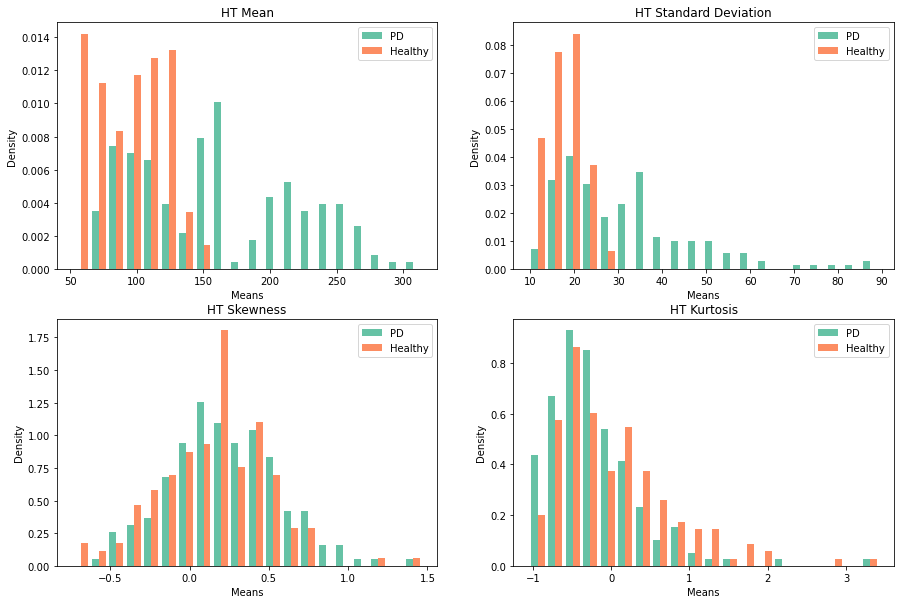

In [ ]:
plot_features(df_HT,"HT")

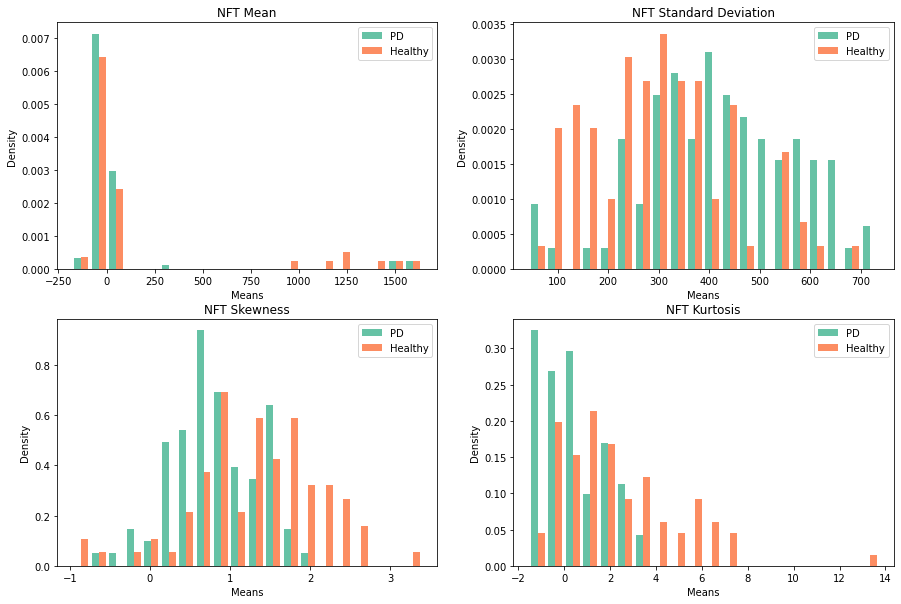

In [ ]:
plot_features(df_NFT, "NFT")

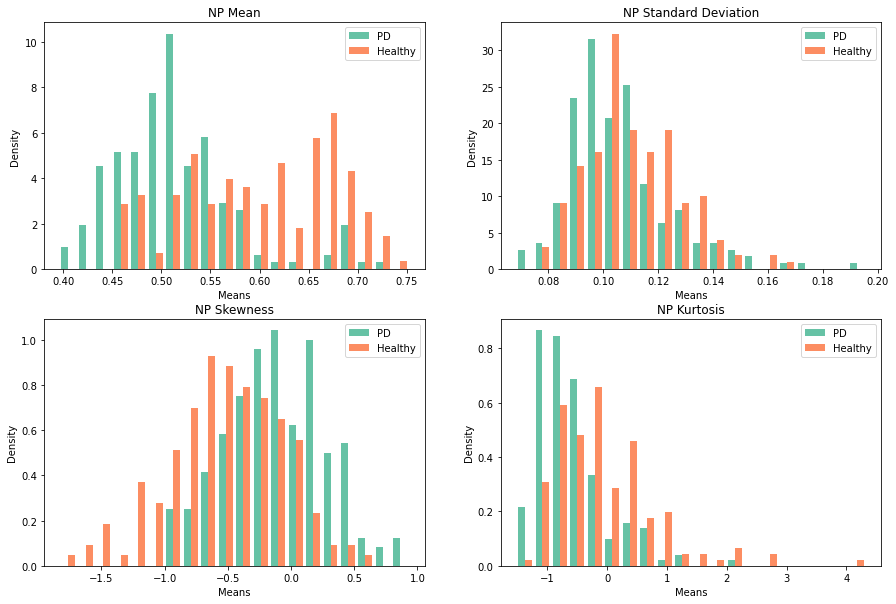

In [ ]:
plot_features(df_NP, "NP")

## Summary 
FT , HT , NP , V, Acc, PChange, PJerk. 
10 cada uno 
70 features en total 

#primero todos lose features, luego seleccionar. 
SVM 
validacion cruzada (1 sujeto fuera)

probar kernels 

medidas: AUC, TP, TN ... 

CORRELACION: SPEARMAN RANK CORRELATION:
. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (fail to reject H0).The intuition for the Spearman’s rank correlation is that it calculates a Pearson’s correlation (e.g. a parametric measure of correlation) using the rank values instead of the real values. Where the Pearson’s correlation is the calculation of the covariance (or expected difference of observations from the mean) between the two variables normalized by the variance or spread of both variables.
Why Spearman? UPDRS item is skewdd(because of the zeros of healthy patients). Also significance of the coefficients. 


In [ ]:
#df_demo = pd.read_excel ("/content/drive/MyDrive/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Demographics_Clinical_Characteristics.xlsx")
df_demo = pd.read_excel ("/Users/mariabaeza/Desktop/Universidad/BigData/TFM/i-PROGNOSIS_DS2.5_Sub1_KeystrokeTimingPressureData/Demographics_Clinical_Characteristics.xlsx")
df_demo= df_demo.drop(df_demo[df_demo["Subject ID"] ==16].index)

(-1.1102851077195106,
 1.1209288414887717,
 -1.1084174822899142,
 1.1004008324899959)

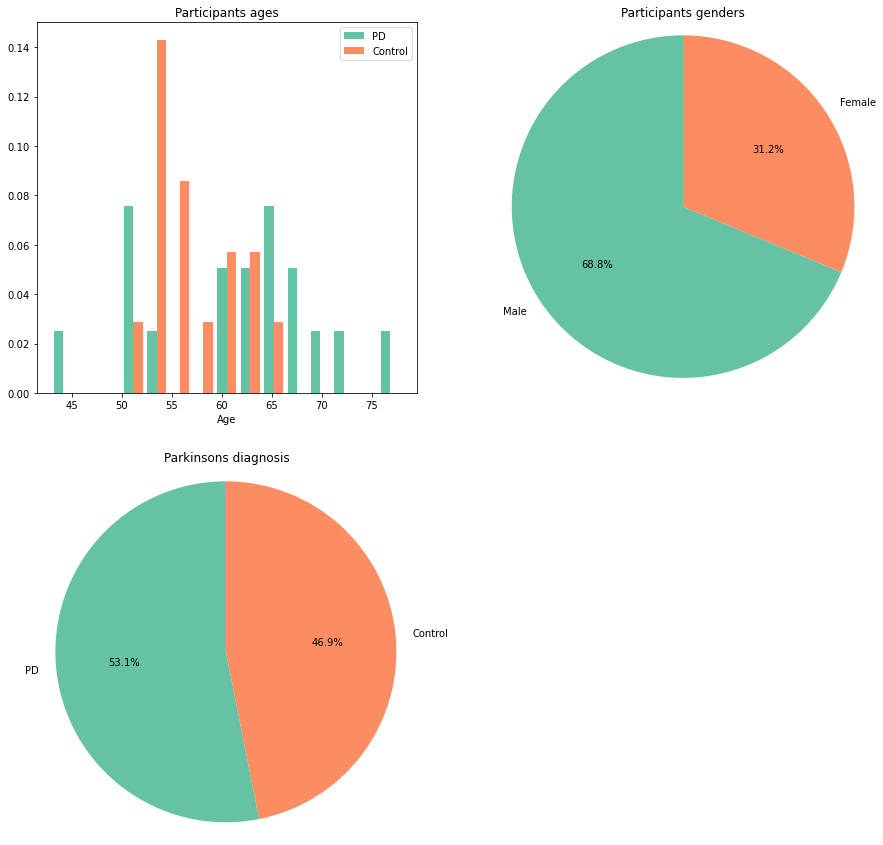

In [ ]:
# AGES sick vs healthy
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1, title="Participants ages")
ax.hist([df_demo["Age (years)"][(df_demo.Group == "PD")], df_demo["Age (years)"][(df_demo.Group == "Control")]], bins=15, histtype='bar',
        color = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]], density=True)
ax.set_xlabel("Age")
ax.set_ylabel("")
ax.legend(["PD", "Control"])


ax = fig.add_subplot(2, 2, 2, title="Participants genders")
ax.pie(df_demo.Gender.value_counts(), labels=["Male", "Female"], colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
       startangle=90, autopct='%1.1f%%')
ax.axis('equal')

ax = fig.add_subplot(2, 2, 3, title="Parkinsons diagnosis")
ax.pie(df_demo.Group.value_counts(), labels=["PD", "Control"], colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]],
       startangle=90, autopct='%1.1f%%')
ax.axis('equal')

In [ ]:
from sklearn.preprocessing import LabelEncoder
temp_df = df_demo.copy()
temp_df['Gender'] = LabelEncoder().fit_transform(temp_df['Gender'])
temp_df['Dominant hand'] = LabelEncoder().fit_transform(temp_df['Dominant hand'])
temp_df['Group'] = LabelEncoder().fit_transform(temp_df['Group'])
temp_df['Education level'] = LabelEncoder().fit_transform(temp_df['Education level'])
temp_df
temp_df.corr()['Group'].sort_values(ascending=False)


Group                                              1.000000
Hoehn & Yahr stage                                 0.920734
UPDRS_III Item 23 Finger Taps-Right hand           0.895948
UPDRS_III Item 22 Rigidity-Right hand              0.895948
UPDRS_III Total score                              0.820015
UPDRS_III Item 21 Tremor-Right hand                0.727607
Years from diagnosis                               0.716833
Levodopa Equivalent Daily Dose (LEDD) (mg)         0.666208
UPDRS_III Item 31 Body Bradykinesia/Hypokinesia    0.664211
UPDRS_III Item 23 Finger Taps-Left hand            0.611712
UPDRS_III Item 22 Rigidity-Left hand               0.602272
UPDRS_III Item 21 Tremor-Left hand                 0.377744
Age (years)                                        0.325625
Gender                                             0.312428
Years of smartphone usage                          0.167633
Education level                                   -0.231756
Subject ID                              

In [ ]:
def obtain_corr(df_input):
    cc_HY = np.zeros(df_input.shape[1]-1)
    cc_UPDRS = np.zeros(df_input.shape[1]-1)
    cc_UPDRS_R = np.zeros(df_input.shape[1]-1)
    cc_UPDRS_L = np.zeros(df_input.shape[1]-1)
    p_HY = np.zeros(df_input.shape[1]-1)
    p_UPDRS = np.zeros(df_input.shape[1]-1)
    p_UPDRS_R = np.zeros(df_input.shape[1]-1)
    p_UPDRS_L = np.zeros(df_input.shape[1]-1)
    dff = df_input.groupby("SubjectID").mean()
    for i in list(range(0,df_input.shape[1]-1)):
        cc_HY[i],p_HY[i] = spearmanr(df_demo.iloc[:,8],dff.iloc[:,i])
        cc_UPDRS[i],p_UPDRS[i] = spearmanr(df_demo.iloc[:,11],dff.iloc[:,i])
        cc_UPDRS_R[i],p_UPDRS_R[i] = spearmanr(df_demo.iloc[:,16],dff.iloc[:,i])
        cc_UPDRS_L[i],p_UPDRS_L[i] = spearmanr(df_demo.iloc[:,17],dff.iloc[:,i])
        
    rho = pd.DataFrame()
    rho = rho.append(pd.Series(cc_HY, name="HY"))
    rho = rho.append(pd.Series(cc_UPDRS, name="UPDRS"))
    rho = rho.append(pd.Series(cc_UPDRS_R, name="UPDRS_R"))
    rho = rho.append(pd.Series(cc_UPDRS_L,name="UPDRS_L"))
    
    pval = pd.DataFrame()
    pval = pval.append(pd.Series(p_HY, name="HY"))
    pval = pval.append(pd.Series(p_UPDRS, name="UPDRS"))
    pval = pval.append(pd.Series(p_UPDRS_R, name="UPDRS_R"))
    pval = pval.append(pd.Series(p_UPDRS_L,name="UPDRS_L"))
    rho.columns=df_input.columns[0:-1]
    pval.columns=df_input.columns[0:-1]
    
    p = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.01,0.05] if x<=t]))
    prueba = rho.round(2).astype(str) + p

    return prueba
    

In [ ]:
NP_corr = obtain_corr(df_NP)
NP_corr

,NP Mean,NP Median,NP SD,NP Skewness,NP Kurtosis,NP SD Mean,NP SD Median,NP SD SD,NP SD Skewness,NP SD Kurtosis
HY,-0.59***,-0.59***,-0.27,0.49**,-0.54**,0.36*,0.53**,0.12,0.35,-0.32
UPDRS,-0.62***,-0.63***,-0.22,0.55**,-0.57***,0.37*,0.58***,0.13,0.34,-0.37*
UPDRS_R,-0.6***,-0.61***,-0.3,0.62***,-0.55**,0.3,0.51**,0.0,0.33,-0.4*
UPDRS_L,-0.56***,-0.55**,-0.08,0.36*,-0.39*,0.31,0.49**,0.19,0.3,-0.19


In [ ]:
HT_corr = obtain_corr(df_HT)
HT_corr

,HT Mean,HT Median,HT SD,HT Skewness,HT Kurtosis,HT SD Mean,HT SD Median,HT SD SD,HT SD Skewness,HT SD Kurtosis
HY,0.47**,0.47**,0.58***,0.19,-0.38*,0.57***,0.49**,0.62***,0.33,-0.17
UPDRS,0.51**,0.52**,0.65***,0.22,-0.34,0.6***,0.51**,0.68***,0.34,-0.08
UPDRS_R,0.6***,0.6***,0.68***,0.39*,-0.33,0.64***,0.54**,0.7***,0.22,-0.07
UPDRS_L,0.27,0.28,0.47**,0.02,-0.22,0.38*,0.33,0.49**,0.44*,-0.09


In [ ]:
NFT_corr = obtain_corr(df_NFT)
NFT_corr

,NFT Mean,NFT Median,NFT SD,NFT Skewness,NFT Kurtosis,NFT SD Mean,NFT SD Median,NFT SD SD,NFT SD Skewness,NFT SD Kurtosis
HY,-0.28,-0.23,0.44*,-0.53**,-0.57***,0.57***,0.55**,0.57***,-0.11,-0.55**
UPDRS,-0.26,-0.18,0.41*,-0.51**,-0.55**,0.57***,0.55**,0.57***,-0.08,-0.52**
UPDRS_R,-0.26,-0.17,0.32,-0.48**,-0.49**,0.54**,0.49**,0.56***,0.04,-0.43*
UPDRS_L,-0.12,-0.04,0.34,-0.47**,-0.47**,0.42*,0.43*,0.38*,-0.09,-0.5**


In [ ]:
V_corr = obtain_corr(df_v)
V_corr

,Velocity Mean,Velocity Median,Velocity SD,Velocity Skewness,Velocity Kurtosis,Velocity SD Mean,Velocity SD Median,Velocity SD SD,Velocity SD Skewness,Velocity SD Kurtosis
HY,-0.62***,-0.61***,-0.58***,0.26,-0.59***,-0.34,-0.32,-0.47**,-0.52**,-0.3
UPDRS,-0.6***,-0.59***,-0.56***,0.23,-0.57***,-0.32,-0.29,-0.48**,-0.5**,-0.38*
UPDRS_R,-0.56***,-0.55***,-0.51**,0.16,-0.53**,-0.28,-0.28,-0.43*,-0.47**,-0.36*
UPDRS_L,-0.48**,-0.48**,-0.48**,0.27,-0.47**,-0.3,-0.26,-0.4*,-0.41*,-0.29


In [ ]:
A_corr = obtain_corr(df_a)
A_corr

,Acceleration Mean,Acceleration Median,Acceleration SD,Acceleration Skewness,Acceleration Kurtosis,Acceleration SD Mean,Acceleration SD Median,Acceleration SD SD,Acceleration SD Skewness,Acceleration SD Kurtosis
HY,-0.62***,-0.62***,-0.6***,-0.24,-0.59***,-0.48**,-0.44*,-0.48**,-0.5**,-0.27
UPDRS,-0.6***,-0.6***,-0.58***,-0.27,-0.58***,-0.44*,-0.4*,-0.47**,-0.48**,-0.36*
UPDRS_R,-0.56***,-0.56***,-0.56***,-0.35*,-0.52**,-0.43*,-0.4*,-0.45*,-0.45*,-0.34
UPDRS_L,-0.48**,-0.48**,-0.45**,-0.11,-0.48**,-0.34,-0.3,-0.36*,-0.4*,-0.28


In [ ]:
PC_corr = obtain_corr(df_pc)
PC_corr

,PChange Mean,PChange Median,PChange SD,PChange Skewness,PChange Kurtosis,PChange SD Mean,PChange SD Median,PChange SD SD,PChange SD Skewness,PChange SD Kurtosis
HY,-0.2,-0.05,-0.28,0.24,-0.55**,0.37*,0.36*,0.21,0.22,-0.24
UPDRS,-0.23,-0.15,-0.23,0.33,-0.58***,0.37*,0.4*,0.21,0.17,-0.29
UPDRS_R,-0.19,-0.13,-0.3,0.26,-0.52**,0.33,0.3,0.15,0.16,-0.19
UPDRS_L,-0.22,-0.19,-0.1,0.27,-0.44*,0.27,0.33,0.21,0.15,-0.29


In [ ]:
PJ_corr = obtain_corr(df_pj)
PJ_corr

,PJerk Mean,PJerk Median,PJerk SD,PJerk Skewness,PJerk Kurtosis,PJerk SD Mean,PJerk SD Median,PJerk SD SD,PJerk SD Skewness,PJerk SD Kurtosis
HY,-0.32,0.29,-0.29,-0.46**,-0.54**,0.52**,0.57***,0.22,0.54**,-0.24
UPDRS,-0.18,0.34,-0.25,-0.49**,-0.55***,0.52**,0.6***,0.23,0.5**,-0.26
UPDRS_R,-0.18,0.42*,-0.32,-0.58***,-0.53**,0.48**,0.51**,0.18,0.47**,-0.19
UPDRS_L,-0.16,0.18,-0.1,-0.31,-0.38*,0.44*,0.54**,0.18,0.42*,-0.2


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from os import cpu_count
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, SVR
from collections import namedtuple
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import svm
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,cross_val_score,RandomizedSearchCV,GridSearchCV,GroupKFold, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import lightgbm
import seaborn as sns
import umap.umap_ as umap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Getting back the objects:
import pickle
import os 
#os.chdir("/content/drive/MyDrive/TFM")
os.chdir("/Users/mariabaeza/Desktop/Universidad/BigData/TFM")
with open('features.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    data,X,y,a,groups,df_demo, pd_patients = pickle.load(f)
logo = LeaveOneGroupOut()
cv = logo.split(X,y,groups)

In [ ]:
data.corr().style.background_gradient(cmap='coolwarm')

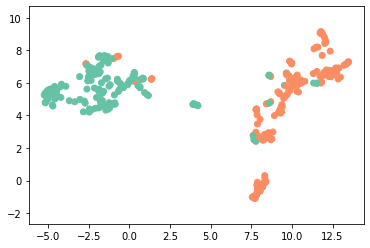

In [ ]:
import umap.umap_ as umap
X_t=[]
umapModel = umap.UMAP(n_neighbors = 5, n_components=2,random_state=42, metric = "hamming")
#imp = IterativeImputer(random_state=0, estimator=BayesianRidge())
imp = SimpleImputer()
X_t = preprocessing.StandardScaler().fit_transform(data)
X_t = pd.DataFrame(imp.fit_transform(X_t), columns= data.columns)
embedding = umapModel.fit_transform(X_t)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette("Set2")[x] for x in data.Class])
plt.gca().set_aspect('equal', 'datalim')
plt.savefig('/Users/mariabaeza/Desktop/Universidad/BigData/TFM/Resultados/umap.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

explained variance ratio (first two components): [0.26046188 0.09011219]


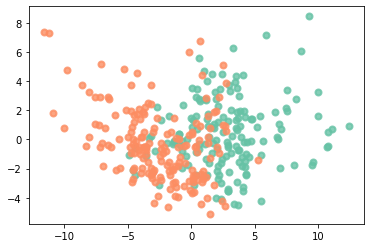

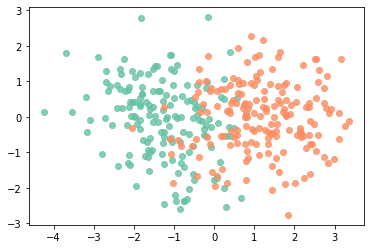

In [ ]:
pca = PCA(n_components=2)

X_r = pca.fit(X_t).transform(X_t)
X_imp = SimpleImputer().fit_transform(X)
lda = LinearDiscriminantAnalysis(n_components=1)
X_r2 = LinearDiscriminantAnalysis(n_components=1).fit_transform(X_imp,y)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[1]]
lw = 2
target_names = ["Healthy", "Parkinson"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

plt.savefig('/Users/mariabaeza/Desktop/Universidad/BigData/TFM/Resultados/pca.eps', format='eps')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], np.random.normal(0, 1, len(X_r2[y == i])), alpha=.8, color=color,
                label=target_name)

plt.savefig('/Users/mariabaeza/Desktop/Universidad/BigData/TFM/Resultados/lda.eps', format='eps')

plt.show()